# Introduction

This is a simplification of my figuring out how to submit seqspec files to the IGVF DACC.

- [Python environment](#Setup)
- [Seqspec template function](#Template)
- [Working out steps needed to create seqspec objects](#Working-out-steps-needed-to-create-seqspec-objects)
- [Exploring boto3](#Exploring-boto3)
- [Seqspec submission functions](#Seqspec-Submission-functions)
- [Create seqspec objects for remaining fastqs](#Create-seqspec-objects-for-remaining-fastqs)

# Setup

First we start with general imports

In [1]:
import hashlib
import requests
from pathlib import Path
from io import StringIO, BytesIO
import sys
import json
from jsonschema import Draft4Validator
import logging
import pandas
import os
import sys
from urllib.parse import urlparse
import yaml
import numpy

In [2]:
try:
    import boto3
except ImportError:
    !{sys.executable} -m pip install --user boto3
    import boto3
    
from botocore.exceptions import ClientError
    

In [3]:
try:
    from jinja2 import Environment
except ImportError:
    !{sys.executable} -m pip install --user jinja2
    from jinja2 import Environment

from jinja2 import FileSystemLoader, select_autoescape, Undefined, StrictUndefined, make_logging_undefined



logger = logging.getLogger(__name__)
LoggingUndefined = make_logging_undefined(
    logger=logger,
    base=Undefined
)

env = Environment(
    loader=FileSystemLoader("templates"),
    autoescape=select_autoescape(),
    undefined=LoggingUndefined,
)

I want to be able to use the seqspec validator while I was writing my seqspec file.

I have the repository checked out into ~/proj/seqspec. This block should either import it for me, or install it if someone elese runs it.

In [4]:
try:
    import seqspec
except ImportError:
    seqspec_root = Path("~/proj/seqspec").expanduser()
    if seqspec_root.exists() and str(seqspec_root) not in sys.path:
        sys.path.append(str(seqspec_root))
    else:
        !{sys.executable} -m pip install --user seqspec
    import seqspec

Import pieces of seqspec that we need for this notebook.

In [5]:
from seqspec.Assay import Assay
from seqspec.Region import Region
from seqspec.Region import Onlist
from seqspec.utils import load_spec_stream
from seqspec.seqspec_index import run_index, get_index
from seqspec.seqspec_print import run_print_sequence_spec, run_print_library_tree, run_print_library_png
from seqspec.seqspec_onlist import run_list_onlists, run_onlist_read, run_find_by_type

I have my own API for interacting with the IGVF database server (which is very much like the old ENCODE database server)

In [6]:
try:
    from encoded_client import encoded
except ImportError:
    encoded_root = Path("~/proj/encoded_client").expanduser()
    if encoded_root.exists() and str(encoded_root) not in sys.path:
        sys.path.append(str(encoded_root))
    else:
        !{sys.executable} -m pip install --user encoded_client
        
    from encoded_client import encoded

encoded_client will pull submitter credentials from either DCC_API_KEY and DCC_SECRET_KEY or from a .netrc file loaded from your home directory. (replacing the {DCC_API_KEY} and {DCC_SECRET_KEY} strings with your specific values.)

The format of a .netrc file is a plain text file with records of the format:

<pre>machine api.sandbox.igvf.org login {DCC_API_KEY} password {DCC_SECRET_KEY}</pre>

Or api.data.igvf.org

(it's also possible to list the fields on separate lines, but I think it's easier to read when they're on one line)

or after creating the server object call:

<pre>server.username = "{DCC_API_KEY}"
server.password = "{DCC_SECRET_KEY}"</pre>



## submission variables

In [7]:
server_name = "api.sandbox.igvf.org"
award = "/awards/HG012077/"
lab = "/labs/ali-mortazavi/"

In [8]:
server = encoded.ENCODED(server_name)
igvf_validator = encoded.DCCValidator(server)

In [9]:
def seqspec_validate(schema, spec):
    """Validate a yaml object against a json schema
    """
    validator = Draft4Validator(schema)

    for idx, error in enumerate(validator.iter_errors(spec), 1):
        print(f"[{idx}] {error.message}")

In [10]:
schema_path = seqspec_root / "seqspec"/ "schema" / "seqspec.schema.json"

with open(schema_path, "rt") as instream:
    seqspec_schema = json.load(instream)

In [11]:
def load_spec(filename):
    with open(filename, "rt") as instream:
        data = yaml.load(instream, Loader=yaml.Loader)
        for r in data.assay_spec:
            r.set_parent_id(None)
    return data

# Template

First build up lists of barcodes onlists needed for this protocol the names will be passed to the template.

In [12]:
barcode_sets = {
    "parse-wt-v2": {
        # onlist1_n96_v4
        "barcode_1_url": "https://data.igvf.org/tabular-files/IGVFFI0924TKJO/@@download/IGVFFI0924TKJO.txt.gz",
        #"barcode_1_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc1_n96_v4.txt.gz",
        "barcode_1_location": "remote",
        "barcode_1_md5": "6d5016e63f121b6a64fb3907dd83f358",
        "barcode_2_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        #"barcode_2_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        "barcode_1_location": "remote",
        "barcode_2_md5": "1452e8ef104e6edf686fab8956172072",
        "barcode_3_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        #"barcode_3_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        "barcode_1_location": "remote",
        "barcode_3_md5": "1452e8ef104e6edf686fab8956172072",
    },
    "parse-wt-mega-v2": {
        # need to add barcode urls
        #onlist1_n192_v4
        "barcode_1_location": "remote",        
        "barcode_1_url": "https://data.igvf.org/tabular-files/IGVFFI2591OFQO/@@download/IGVFFI2591OFQO.txt.gz",
        #"barcode_1_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc1_n192_v4.txt.gz",
        #"barcode_1_location": "local",
        #"barcode_1_url": "CB1.txt",
        "barcode_1_md5": "5c3b70034e9cef5de735dc9d4f3fdbde",
        "barcode_2_location": "remote",        
        "barcode_2_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        #"barcode_2_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        #"barcode_2_location": "local",
        #"barcode_2_url": "CB23.txt",
        "barcode_2_md5": "1452e8ef104e6edf686fab8956172072",
        "barcode_3_location": "remote",
        "barcode_3_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        #"barcode_3_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        #"barcode_3_location": "local",
        #"barcode_3_url": "CB23.txt",
        "barcode_3_md5": "1452e8ef104e6edf686fab8956172072",
    }
}

library_kits = {
    "parse-wt-v2": {
        "single": {
            "library_protocol": "Any",
            "library_kit": "Evercode WT v2.0.1 single index",
        },
        "dual": {
            "library_protocol": "Any",
            "library_kit": "Evercode WT v2.0.1 single index",
        },
    },
    "parse-wt-mega-v2": {
        "single": {
            "library_protocol": "Any",
            "library_kit": "Evercode WT Mega v2.0.1 dual index",
        },
        "dual": {
            "library_protocol": "Any",
            "library_kit": "Evercode WT Mega v2.0.1 dual index",
        }
    }
}

# Allowed terms for sequence_kit
# https://data.igvf.org/profiles/sequence_file/schema/properties/?property=sequencing_kit
sequencing_kit_by_platform = {
    # Illumina novaseq 6000 
    # reagent ordering page https://www.illumina.com/products/by-type/sequencing-kits/cluster-gen-sequencing-reagents/novaseq-reagent-kits.html
    "/platform-terms/EFO_0008637/": {
        "sequence_protocol": "Illumina NovaSeq 6000",
        "sequence_kit": "NovaSeq 6000 S4 Reagent Kit v1.5",
    },
    # Illumina NextSeq 2000
    # reagent ordering page https://www.illumina.com/products/by-type/sequencing-kits/cluster-gen-sequencing-reagents/nextseq-1000-2000-reagents.html
    "/platform-terms/EFO_0010963/": {
        "sequence_protocol": "Illumina NextSeq 2000",
        "sequence_kit": "NextSeq 2000 P4 XLEAP-SBS Reagent Kit",
    },
    "/platform-terms/EFO_0008633/": {
        "sequencing_protocol": "ONT Ligation Sequencing Kit V14",
        "sequencing_kit": "ONT GridION X5",
    }
}

Define the the file information needed to define this seqspec.

In [13]:
ont1 = 36
tso = 36
read1_max_length = 36025
read1_min_length = max(min(11, read1_max_length), 100)

read2_min_length = 0
read2_max_length = 0
primer = 6
bc1 = 8
bc1_linker = 30
bc2 = 8
bc2_linker = 22
bc3 = 8
umi = 10
adapter = 34
ont2 = 36
total_min_length = sum([ont1, tso, read1_min_length, primer, bc1, bc1_linker, bc2, bc2_linker, umi, adapter, ont2])
total_max_length = sum([ont1, tso, read1_max_length, primer, bc1, bc1_linker, bc2, bc2_linker, umi, adapter, ont2])
insert_min_length = read1_min_length
insert_max_length = read1_max_length - sum([tso, primer, bc1, bc1_linker, bc2, bc2_linker, umi, adapter])
context = {
    # attributes to use 
    # accession
    # s3_uri
    # minimum_read_length
    # maximum_read_length
    #"read1_accession": "TSTFI76281026",
    #"read1_url": server.prepare_url("/sequence-files/TSTFI76281026/@@download/TSTFI76281026.fastq.gz"),
    "read1_accession": "TSTFI39351339",
    "read1_url": "https://api.sandbox.igvf.org/sequence-files/TSTFI39351339/@@download/TSTFI39351339.fastq.gz",
    "read1_min_length": read1_min_length,
    "read1_max_length": read1_max_length,

    "insert_min_length": insert_min_length,
    "insert_max_length": insert_max_length,

    "total_min_length": total_min_length,
    "total_max_length": total_max_length,
}
# For testing y2ave
context["RNA_fastq_R1"] = Path(context["read1_url"]).name
#context["RNA_fastq_R2"] = Path(context["read2_url"]).name

# Merge in the barcode information
context.update(barcode_sets["parse-wt-mega-v2"])

# Merge in the library information
context.update(library_kits["parse-wt-mega-v2"]["single"])

# Merge in sequencer information
# nextseq
context.update(sequencing_kit_by_platform["/platform-terms/EFO_0010963/"])

# load the template and instantiate it with the context for this specific measurement set.
# this version needs the libspec branch that separates the sequence and library specifications

template_name = "parse-wt-mega-v2-nanopore.yaml.j2"
#template_name = "parse-wt-mega-v2-single-index-libspec-1.yaml.j2"
#template_name = "y2ave_parse_bridge.yaml.j2"
template = env.get_template(template_name)

# this version needs the original version that merges the sequence and library specification concepts
#parse_wt_mega_v2 = env.get_template("parse-wt-mega-v2-single-index-seqspec-0.yaml.j2")

example_yaml = template.render(context)

# validate the generated seqspec file.
example_spec = load_spec_stream(StringIO(example_yaml))
seqspec_validate(seqspec_schema, example_spec.to_dict())

# Print the example for evaluation.
print(example_yaml)

[1] 36251 is greater than the maximum of 2048
[2] 35871 is greater than the maximum of 2048
!Assay
seqspec_version: 0.1.1
assay_id: Evercode-WT-mega-nanpore-v2
doi: "https://docs.google.com/presentation/d/17yKh6xE5b9Mo4DaXx5uPvFZOIHOW0kbK-QsU2ECwx8c/edit#slide=id.g29abb1440dc_0_500"
date: "13 August 2024"
name: Parse Evercode mega WT v2 using nanopore
description: split-pool ligation-based ONT transcriptome sequencing 
modalities:
  - rna
lib_struct: ""
library_protocol: Any
library_kit: Evercode WT Mega v2.0.1 dual index
sequence_protocol: Illumina NextSeq 2000
sequence_kit: NextSeq 2000 P4 XLEAP-SBS Reagent Kit
sequence_spec:
  - !Read
    read_id: TSTFI39351339.fastq.gz
    name: Fastq for TSTFI39351339
    modality: rna
    primer_id: ont-top
    min_len: 100
    max_len: 36025
    strand: pos
    
library_spec:
- !Region
  region_id: rna
  region_type: rna
  name: rna
  sequence_type: joined
  sequence: TTTTTTTTCCTGTACTTCGTTCAGTTACGTATTGCTAAGCAGTGGTATCAACGCAGAGTGAATGGGXXXXXXXXXXXX

In [14]:
27 + 10 + 8 + 22 + 8 + 30 + 8 + 6

119

In [15]:
sum([tso, primer, bc1, bc1_linker, bc2, bc2_linker, umi, adapter])

154

In [16]:
print(run_print_library_tree(example_spec))

                                        ┌─'ont-top:36'
                                        ├─'tso:30'
                                        ├─'cDNA:35871'
                                        ├─'primer:6'
                                        ├─'barcode-1:8'
                                        ├─'linker-1:30'
─────────────────── ──rna───────────────┤
                                        ├─'barcode-2:8'
                                        ├─'linker-2:22'
                                        ├─'barcode-3:8'
                                        ├─'umi:10'
                                        ├─'truseq_read2:34'
                                        └─'ont-bottom:27'


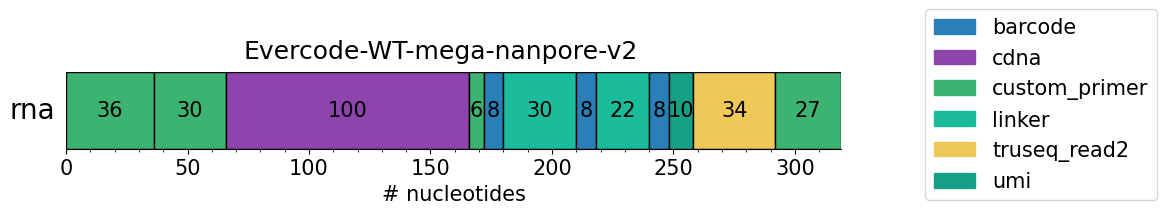

In [17]:
_ = run_print_library_png(example_spec)

In [18]:
run_print_sequence_spec(example_spec)

'TSTFI39351339.fastq.gz\tont-top\tpos\t100\t36025'

In [19]:
def validate_parse_index(example_spec, modality):
    expected_index = "1,10,18,1,48,56,1,78,86:1,0,10:0,0,150"
    expected_parts = expected_index.split(":")
    index_rna = run_index(example_spec, "rna", ["B01_13A_R1.fastq.gz", "B01_13A_R2.fastq.gz"], fmt="kb")
    index_parts = index_rna.split(":")

    assert len(expected_parts) == len(index_parts)
    assert expected_parts[0] == index_parts[0], f"{expected_parts[0]} != {index_parts[0]}"
    assert expected_parts[1] == index_parts[1], f"{expected_parts[1]} != {index_parts[1]}"
    assert expected_parts[2] == index_parts[2], f"{expected_parts[2]} != {index_parts[2]}"

def validate_share_index(example_spec, modality):
    r = ['B01_13A_R1.fastq.gz', 'I1.fastq.gz', 'B01_13A_R2.fastq.gz']
    index_rna = run_index(example_spec, "rna", r, fmt="kb")
    print(index_rna)
    
{
    "parse-wt-mega-v2-single-index-libspec-1.yaml.j2": validate_parse_index,
    "y2ave_parse_bridge.yaml.j2": validate_share_index,
    "parse-wt-mega-v2-nanopore.yaml.j2": lambda x, y: True,
}[template_name](example_spec, "rna")

True

In [20]:
run_list_onlists(example_spec, "rna")

[{'region_id': 'barcode-1',
  'filename': 'barcode-1_onlist_v2.txt',
  'location': 'local',
  'md5': '5c3b70034e9cef5de735dc9d4f3fdbde'},
 {'region_id': 'barcode-2',
  'filename': 'barcode-23_onlist.txt',
  'location': 'local',
  'md5': '1452e8ef104e6edf686fab8956172072'},
 {'region_id': 'barcode-3',
  'filename': 'barcode-23_onlist.txt',
  'location': 'local',
  'md5': '1452e8ef104e6edf686fab8956172072'}]

In [21]:
example_spec.get_libspec("rna").get_region_by_region_type("barcode")

[{'region_id': 'barcode-1', 'region_type': 'barcode', 'name': 'barcode-1', 'sequence_type': 'onlist', 'onlist': {'filename': 'barcode-1_onlist_v2.txt', 'location': 'local', 'md5': '5c3b70034e9cef5de735dc9d4f3fdbde'}, 'sequence': 'NNNNNNNN', 'min_len': 8, 'max_len': 8, 'regions': None},
 {'region_id': 'barcode-2', 'region_type': 'barcode', 'name': 'barcode-2', 'sequence_type': 'onlist', 'onlist': {'filename': 'barcode-23_onlist.txt', 'location': 'local', 'md5': '1452e8ef104e6edf686fab8956172072'}, 'sequence': 'NNNNNNNN', 'min_len': 8, 'max_len': 8, 'regions': None},
 {'region_id': 'barcode-3', 'region_type': 'barcode', 'name': 'barcode-3', 'sequence_type': 'onlist', 'onlist': {'filename': 'barcode-23_onlist.txt', 'location': 'local', 'md5': '1452e8ef104e6edf686fab8956172072'}, 'sequence': 'NNNNNNNN', 'min_len': 8, 'max_len': 8, 'regions': None}]

In [22]:
joined_name = run_onlist_read(example_spec, "rna", "B01_13A_R2.fastq.gz")
joined_name

IndexError: region_id B01_13A_R2.fastq.gz not found in reads ['TSTFI39351339.fastq.gz']

In [ ]:
if joined_name is not None:
    joined = pandas.read_csv("onlist_joined.txt", header=None, sep=" ")
    print("length = ", joined.shape[0])
    print(joined)

In [ ]:
assert numpy.all(joined.loc[0].values == ["AACGTGAT", "AACGTGAT", "CATTCCTA"])

In [ ]:
!rm onlist_joined.txt

In [23]:
example_spec.update_spec()

In [24]:
print(example_spec.to_YAML())

!Assay
seqspec_version: 0.1.1
assay_id: Evercode-WT-mega-nanpore-v2
doi: https://docs.google.com/presentation/d/17yKh6xE5b9Mo4DaXx5uPvFZOIHOW0kbK-QsU2ECwx8c/edit#slide=id.g29abb1440dc_0_500
date: 13 August 2024
name: Parse Evercode mega WT v2 using nanopore
description: split-pool ligation-based ONT transcriptome sequencing
modalities:
- rna
lib_struct: ''
library_protocol: Any
library_kit: Evercode WT Mega v2.0.1 dual index
sequence_protocol: Illumina NextSeq 2000
sequence_kit: NextSeq 2000 P4 XLEAP-SBS Reagent Kit
sequence_spec:
- !Read
  read_id: TSTFI39351339.fastq.gz
  name: Fastq for TSTFI39351339
  modality: rna
  primer_id: ont-top
  min_len: 100
  max_len: 36025
  strand: pos
library_spec:
- !Region
  region_id: rna
  region_type: rna
  name: rna
  sequence_type: joined
  sequence: TTTTTTTTCCTGTACTTCGTTCAGTTACGTATTGCTAAGCAGTGGTATCAACGCAGAGTGAATGGGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNGTGGCCGATGTTTCGCAT